In [535]:
using LinearAlgebra
using PyPlot
using ControlSystems
using ForwardDiff

In [536]:
#Model parameters
g = 9.81 #m/s^2
m = 1.0 #kg 
ℓ = 0.3 #meters

h = 0.2 #time step (5 Hz)

0.2

In [537]:
#Planar Quadrotor Dynamics
function quad_dynamics(x,u)
    θ = x[3]
    
    ẍ = (1/m)*(u[1] + u[2])*sin(θ)
    ÿ = (1/m)*(u[1] + u[2])*cos(θ) - g
    θ̈ = (1/(0.2*m*ℓ*ℓ))*(ℓ/2)*(u[2] - u[1])
    
    return [x[4:6]; ẍ; ÿ; θ̈]
end

quad_dynamics (generic function with 1 method)

In [538]:
function quad_dynamics_rk4(x,u)
    #RK4 integration with zero-order hold on u
    f1 = quad_dynamics(x, u)
    f2 = quad_dynamics(x + 0.5*h*f1, u)
    f3 = quad_dynamics(x + 0.5*h*f2, u)
    f4 = quad_dynamics(x + h*f3, u)
    return x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
end

quad_dynamics_rk4 (generic function with 1 method)

In [539]:
#Linearized dynamics for hovering
x_hover = zeros(6)
u_hover = [0.5*m*g; 0.5*m*g]
A = ForwardDiff.jacobian(x->quad_dynamics_rk4(x,u_hover),x_hover);
B = ForwardDiff.jacobian(u->quad_dynamics_rk4(x_hover,u),u_hover);

In [540]:
n = 6     # number of state
m = 2     # number of controls
Tfinal = 10.0 # final time
N = Int(Tfinal/h)+1    # number of time steps
thist = Array(range(0,h*(N-1), step=h));

In [541]:
#2D Quadrotor Problem
x0 = [1.0; -0.5; 0; 0; 0; 0]

#LQR Cost Matrices
Q = Array(1.0*I(n))
R = Array(0.1*I(m))
#Qf = Array(1.0*I(2));
Qf = dare(A,B,Q,R); #This makes sure that the infinite-horizon K is the solution to the finite-horizon problem

In [542]:
#Cost Function
function cost(xtraj,utraj,Q,R,Qf)
    J = 0.0
    for k = 1:(N-1)
        J += 0.5*xtraj[:,k]'*Q*xtraj[:,k] + 0.5*(utraj[k]'*R*utraj[k])[1]
    end
    J += 0.5*xtraj[:,N]'*Qf*xtraj[:,N]
end

function cost(x0,K)
    xt = zeros(eltype(K),n,N)
    ut = zeros(eltype(K),m,N-1)
    rollout!(xt,ut,x0,K)
    J = 0.0
    for k = 1:(N-1)
        J += 0.5*xt[:,k]'*Q*xt[:,k] + 0.5*(ut[k]'*R*ut[k])[1]
    end
    J += 0.5*xt[:,N]'*Qf*xt[:,N]
end

cost (generic function with 2 methods)

In [543]:
#Groud Truth Solution (Infinite-Horizon LQR Gain)
K_true = dlqr(A,B,Q,R)

2×6 Matrix{Float64}:
 -0.173043  1.32479  -1.5023  -0.287999  1.75495  -0.430164
  0.173043  1.32479   1.5023   0.287999  1.75495   0.430164

In [544]:
#Ground-truth Closed-loop simulation with LQR controller

function rollout!(xtraj,utraj,x0,K)
    xtraj[:,1] .= x0
    for k = 1:(N-1)
        utraj[:,k] .= -K*xtraj[:,k]
        xtraj[:,k+1] .= A*xtraj[:,k] + B*utraj[:,k]
    end
end
    
xtraj_true = zeros(n,N)
utraj_true = zeros(m,N-1)

rollout!(xtraj_true,utraj_true,x0,K_true)

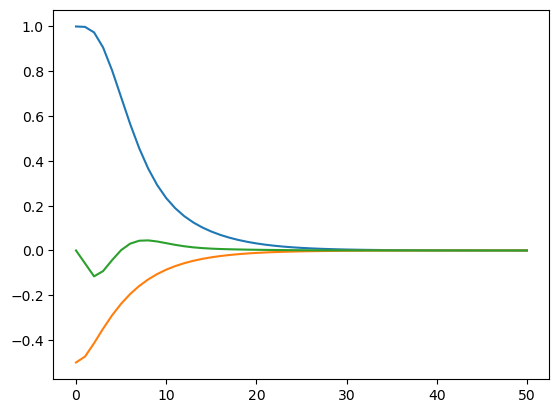

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x1e8758d30>

In [545]:
plot(xtraj_true[1,:])
plot(xtraj_true[2,:])
plot(xtraj_true[3,:])

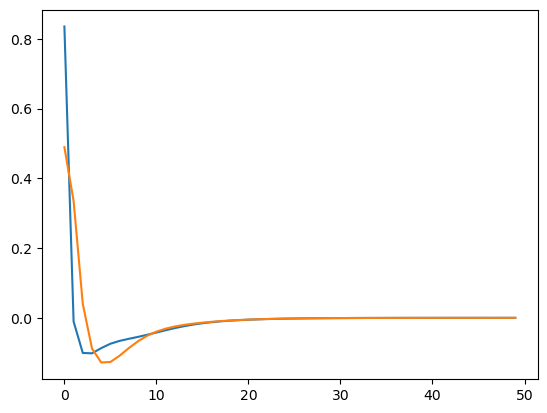

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x1e87ca6a0>

In [546]:
plot(utraj_true[1,:])
plot(utraj_true[2,:])

In [547]:
#Gradient Descent w/Momentum + Line Search
iter = 300 #number of outer-loop iterations
β1 = 0.5

K = zeros(m,n)
iter_costs = zeros(iter)

grad_m = zeros(m,n)

xtraj_pg = zeros(n,N)
utraj_pg = zeros(m,N-1);

for k = 1:iter
    
    x0_k = x0 + 0.1*randn(6)
    
    #Do a rollout with current policy
    c_old = cost(x0_k,K)
    
    #Evaluate gradient w.r.t. K
    grad = ForwardDiff.gradient(dK->cost(x0_k,dK),K)
    
    #Gradient w/momentum
    grad_m = β1*grad_m + (1-β1)*grad
    
    #Line search
    α = 10.0
    K_new = K - α*grad_m
    c_new = cost(x0_k,K_new)
    while isnan(c_new) || c_new > c_old
        α = 0.5*α
        K_new = K - α*grad_m
        c_new = cost(x0_k,K_new)
    end
    
    K .= K_new
    
    #Store cost for plotting
    iter_costs[k] = c_new #cost(x0,K)
end

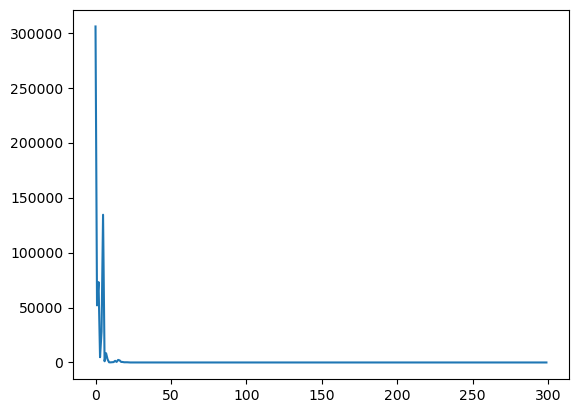

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x1e892d640>

In [548]:
plot(iter_costs)

In [549]:
cost(x0,K)

4.990295541940446

In [550]:
c_true = cost(x0,K_true)

4.988733286898742

In [551]:
K_true

2×6 Matrix{Float64}:
 -0.173043  1.32479  -1.5023  -0.287999  1.75495  -0.430164
  0.173043  1.32479   1.5023   0.287999  1.75495   0.430164

In [552]:
K

2×6 Matrix{Float64}:
 -0.236409  1.10665  -1.27511  -0.229501  1.81207  -0.34516
  0.10861   1.11603   1.73499   0.350503  1.8147    0.515023

In [553]:
norm.(eigvals(A-B*K))

6-element Vector{Float64}:
 0.018838581222544684
 0.3721062878171307
 0.6456809095586935
 0.6456809095586935
 0.8257923805474477
 0.8558110236359553

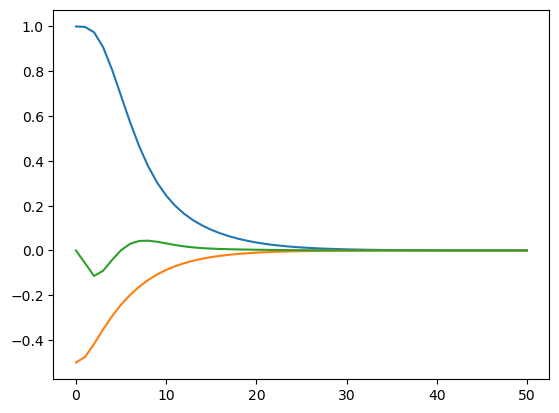

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x1e899e1f0>

In [554]:
rollout!(xtraj_pg,utraj_pg,x0,K)
plot(xtraj_pg[1,:])
plot(xtraj_pg[2,:])
plot(xtraj_pg[3,:])